In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// Code to be able to number equations in the markdown

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Explicit finite difference scheme

### Rewriting equation in terms of row (position) and column (time) indicies.

The equation (Eq. 4.0 in doc) given to me by Jack is: 

\begin{equation}
E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})
\end{equation}

where $ \displaystyle r = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 $ and n is the position index and i is the time index (dimensionless)

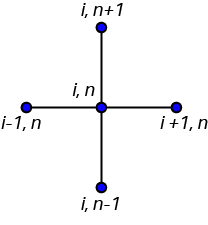

Using the image above, we use [i,n] ; [i-1,n] ; [i+1,n] ; [i, n-1] and take a weighted average to find [i,n+1].

### Defining global arrays for I, E, T_e, T_i, n_e, rho


In [3]:
I = np.zeros((10, 10))
E = np.zeros((10, 10))
T_e = np.zeros((10, 10))
T_i = np.zeros((10, 10))
n_e = np.zeros((10, 10))
rho = np.zeros((10, 10))

### Defining parameters needed to solve differential equation: $ \nabla^{2} E - \frac{n^2}{c^2} \frac{\partial^2 E}{\partial t^{2}} = 0$

In [295]:
# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm # we choose wavelength

# time-step size “dt” is strictly controlled by Courant–Friedrichs–Lewy (CFL) condition 
#so that the wave propagation distance within a allowed time-step size cannot exceed the grid size “dx”.
CFL = 0.1
delta_x = 0.001 * wavelength
delta_t = CFL * delta_x / speed_of_light    # time related time-step

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)
period = wavelength / speed_of_light        # wave period (can also be calculated with 1/f)

# Grid and time parameters
# T = 1 * ps              # time in seconds (* picoseonds) (in the future, will represent modeling time)
T = period
n_timestep = int(T/delta_t)        # n time step
n_cycles = period / delta_t  # number of timesteps to finish one period
ntimestep_dividedby_ncycle = n_timestep / n_cycles # equal to number of periods passing through simulation time 
# L = 500 * nm            # length in SI units in meters
L = wavelength
n_cells = int(L/delta_x)            # number of cells (can also think of as number of grid points)
# delta_x = L/n_cells     # spatial time-step (can also think of as grid spacing)



### Initializing laser intensity and electric field

In [206]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space) ) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

### Solving explicitly using Eq (1): $E^{n+1}_i = \left ( \frac{\Delta t}{\Delta x} \frac{c}{n} \right )^2 (E^{n}_{i+1} - 2E^{n}_{i} + E^{n}_{i-1})-(-2E^{n}_{i} + E^{n-1}_{i})$

In [207]:
x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

# BEFORE: E = np.zeros((len(x), len(t)))
E = np.zeros((len(t), len(x)))

r_const = ( (delta_t/delta_x) * (speed_of_light/RefractiveIndex) ) ** 2 # our parameter

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*1 + 0):
    t_sim = t[n] # in seconds
    
    # Initial conditions in time:
    E[n-1, 0] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[0] )
    E[n-1, 1] = E_0 * np.sin( angular_frequency * t[n-1] - wavenumber * x[1] )
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E[n, 0] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[0] )
    E[n, 1] = E_0 * np.sin( angular_frequency * t[n] - wavenumber * x[1] )
    
    # We have no laser on the left, so boundary conditions are just 0
    E[n, -1] = 0
    E[n, -2] = 0
    
    # Initial conditions in time:
    E[1, 2:] = 0
    for i in range(2, len(x) - 3):
        E[n+1, i] = (r_const) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) - ( -2*E[n, i] + E[n-1, i] )
        
#         print('E[n+1, i]/E_0', E[n+1, i]/E_0)
        
        # if the ratio is not bounded to from -1 to 1, then we have overshot and are out of simulation physical bounds
        if (False) and abs(E[n+1, i]/E_0) > 1:
            print('stop')
            print('index', index, 'n+1', n+1, 'i', i, 'E[n+1, i]', E[n+1, i], 'E[n+1, i]/E_0', E[n+1, i]/E_0, (r_const) * (E[n, i+1] - 2*E[n, i] + E[n, i-1]), -2*E[n, i] + E[n-1, i], E[n, i-1] * r_const)
            break
    
        index += 1

In [208]:
L/delta_x

999.9999999999999

In [209]:
T/delta_x

3.3356409519815205e-06

In [210]:
T/delta_t

2000.0

In [211]:
r_const

0.25

In [212]:
wavelength

3.51e-07

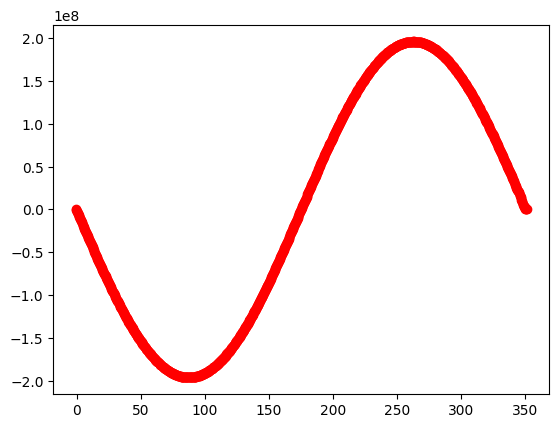

In [213]:
plt.plot(x/nm, E[2000, :], 'ro')

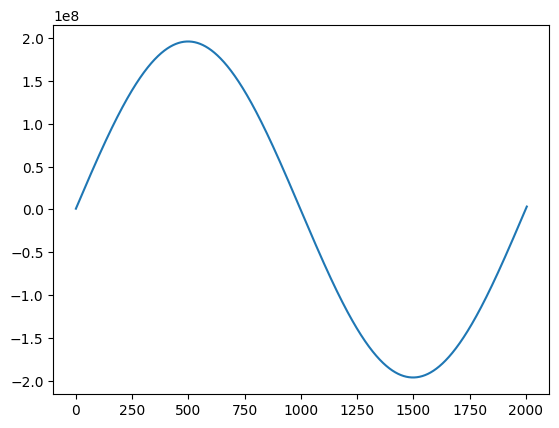

In [214]:
plt.plot(E_0 * np.sin( angular_frequency * t - wavenumber * x[0] ))

In [215]:
delta_t

5.854049870727569e-19

In [216]:
T/delta_t

2000.0

In [217]:
(delta_t * 600) / period

0.30000000000000004

## Modeling the damping wave

In [377]:
# defining complex index of refraction
n_r = 1
# n_i = 6.48
n_i = 0.1
# complex_refractive_index = np.cdouble(complex(n_r, n_i))
complex_refractive_index = complex(n_r, n_i)

In [378]:
complex_refractive_index

(1+0.1j)

In [379]:
R = 25 * um # radius of laser
E_L = 10 * (10 ** -6) # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2 # area of laser
T_laser = 100 * ps # laser pulse time
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12

# Electric field (same as before but now using complex refractive index)
refract_index_ghost = 1
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * refract_index_ghost * permittivity_free_space)) # SI unit is voltage / m

# Laser intensity
I_0 = E_L / (Area_L * T_laser) # laser intensities (SI unit is Joules/(m**2) * s )

In [380]:
E_0

195891384.73574314

In [381]:
x = []  # spatial domain (can also think of as coordinates of grid points)
t = []  # time domain

# Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
# The ghost cells are there so that in the matrix we can access all indeces
# To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
for i in range(-2, n_cells + 3):
    x.append(delta_x * (i + 0.5))

for i in range(-2, n_timestep + 3):
    t.append(delta_t * (i + 0.5))
    
x = np.array(x)
t = np.array(t)

E = 1j * np.zeros((len(t), len(x)))

r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter

# These loops will go through the grid. We start at 1 so as to not calculate the
# value when the a time or spatial point is equal to 0.
index = 0
for n in range(1, (len(t) - 3)*1 + 0):
    t_sim = t[n] # in seconds
    
    # Defning cos and sin terms for wave to later be turned into complex numbers for t_nm1
    cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
    sin_term_0_t_nm1 = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
    
    cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
    sin_term_1_t_nm1 = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
    
#     print('cos_term_0_t_nm1', cos_term_0_t_nm1)
#     print('sin_term_0_t_nm1', sin_term_0_t_nm1)
#     print('cos_term_1_t_nm1', cos_term_1_t_nm1)
#     print('sin_term_1_t_nm1', sin_term_1_t_nm1)

    
    # Initial conditions in time:
    E[n-1, 0] = complex(cos_term_0_t_nm1, sin_term_0_t_nm1)
    E[n-1, 1] = complex(cos_term_1_t_nm1, sin_term_1_t_nm1)

    
    # Defning cos and sin terms for wave to later be turned into complex numbers for t_n
    cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
    sin_term_0_t_n = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
    
    cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
    sin_term_1_t_n = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
    
#     print('cos_term_0_t_n', cos_term_0_t_n)
#     print('sin_term_1_t_n', sin_term_1_t_n)
    
    
    # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
    E[n, 0] = complex(cos_term_0_t_n, sin_term_0_t_n)
    E[n, 1] = complex(cos_term_1_t_n, sin_term_1_t_n)
    
    
    # We have no laser on the left, so boundary conditions are just 0
    E[n, -1] = 0
    E[n, -2] = 0
    
    # Initial conditions in time:
    E[1, 2:] = 0
    for i in range(2, len(x) - 3):
        E[n+1, i] = (r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) - ( -2*E[n, i] + E[n-1, i] )
        
#         print('E[n+1, i]/E_0', E[n+1, i]/E_0)
        
        # if the ratio is not bounded to from -1 to 1, then we have overshot and are out of simulation physical bounds
        if (True) and abs(E[n+1, i])/abs(E_0) > 1:
            print('stop')
            print('index', index, 'n+1', n+1, 'i', i, 'E[n+1, i]', E[n+1, i], 'abs(E[n+1, i])/abs(E_0)', abs(E[n+1, i])/abs(E_0))
            print()
            print('E_0', E_0)
            print()
            print('(r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] )', (r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ))
            print()
            print('( -2*E[n, i] + E[n-1, i] )', ( -2*E[n, i] + E[n-1, i] ))
            
            print('abs( -2*E[n, i] + E[n-1, i] )', abs(( -2*E[n, i] + E[n-1, i] )))
            print()
            print('abs(r_const_complex)', abs(r_const_complex))
            print()
            
            print('E[n, i+1]', E[n, i+1], 'E[n, i]', E[n, i], 'E[n, i-1]', E[n, i-1], 'E[n-1, i]', E[n-1, i])
            print(abs(E[n, i+1]/E_0),  abs(E[n, i]/E_0), abs(E[n, i-1]/E_0), abs(E[n-1, i]/E_0))
            print()
            
            print('cos_term_0_t_nm1', cos_term_0_t_nm1)
            print('sin_term_0_t_nm1', sin_term_0_t_nm1)
            print('cos_term_1_t_nm1', cos_term_1_t_nm1)
            print('sin_term_1_t_nm1', sin_term_1_t_nm1)
            
            print(np.sqrt(cos_term_0_t_nm1 ** 2 + sin_term_0_t_nm1 ** 2))
            print(np.sqrt(cos_term_1_t_nm1 ** 2 + sin_term_1_t_nm1 ** 2))
            
            print(np.sqrt(cos_term_0_t_n ** 2 + sin_term_0_t_n ** 2))
            print(np.sqrt(cos_term_1_t_n ** 2 + sin_term_1_t_n ** 2))
            break
    
        index += 1

stop
index 17982 n+1 20 i 2 E[n+1, i] (17155406.319050565+199574759.62439826j) abs(E[n+1, i])/abs(E_0) 1.022560234000526

E_0 195891384.73574314

(r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) (-406372.605797941-1215926.982570957j)

( -2*E[n, i] + E[n-1, i] ) (-17561778.924848508-200790686.6069692j)
abs( -2*E[n, i] + E[n-1, i] ) 201557227.3750147

abs(r_const_complex) 0.009900990099009903

E[n, i+1] (18418536.3053871+56898007.1294487j) E[n, i] (18550070.79522132+190637020.10283095j) E[n, i-1] (2769256.96247854+195871809.68572965j) E[n-1, i] (19538362.665594134+180483353.5986927j)
0.30529620787061923 0.9777735145886043 0.9999999999999999 0.9267270407144016

cos_term_0_t_nm1 3876835.7714562863
sin_term_0_t_nm1 195853018.25115716
cos_term_1_t_nm1 2646186.5362760285
sin_term_1_t_nm1 195873510.9975368
195891384.73574314
195891384.73574314
195891384.73574314
195891384.7357431
stop
index 17982 n+1 21 i 2 E[n+1, i] (15057279.445863394+206601284.59786826j) abs(E[n+1, i])/abs(E_0) 1.0

stop
index 96903 n+1 183 i 2 E[n+1, i] (354732767.62599295+23528377.51718425j) abs(E[n+1, i])/abs(E_0) 1.8148434436573835

E_0 195891384.73574314

(r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) (-5864501.297562991+3718640.821509214j)

( -2*E[n, i] + E[n-1, i] ) (-360597268.92355597-19809736.695675038j)
abs( -2*E[n, i] + E[n-1, i] ) 361140991.8897041

abs(r_const_complex) 0.009900990099009903

E[n, i+1] 0j E[n, i] (338869266.122463-28146540.14656091j) E[n, i-1] (22780087.356005836+194562335.08503047j) E[n-1, i] (317141263.32137-76102816.98879686j)
0.0 1.7358404283964572 1.0 1.66492506599129

cos_term_0_t_nm1 23879941.35253997
sin_term_0_t_nm1 194430406.61040184
cos_term_1_t_nm1 22657835.746926848
sin_term_1_t_nm1 194576609.83004156
195891384.73574314
195891384.73574314
195891384.73574314
195891384.73574314
stop
index 96903 n+1 184 i 2 E[n+1, i] (364222390.8084935+77980757.75583962j) abs(E[n+1, i])/abs(E_0) 1.9014454175760938

E_0 195891384.73574314

(r_const_complex) * ( E[n,

stop
index 96903 n+1 1026 i 2 E[n+1, i] (7648489187685.872-50306735681489.28j) abs(E[n+1, i])/abs(E_0) 259760.48436647607

E_0 195891384.73574314

(r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) (186269419094.42865+975960879101.8168j)

( -2*E[n, i] + E[n-1, i] ) (-7462219768591.443+51282696560591.1j)
abs( -2*E[n, i] + E[n-1, i] ) 51822771928954.36

abs(r_const_complex) 0.009900990099009903

E[n, i+1] 0j E[n, i] (539331526523.4296-50172679510332.75j) E[n, i-1] (117961358.95884465+156392302.8996937j) E[n-1, i] (-6383556715544.584-49062662460074.4j)
0.0 256139.7902621541 1.0 252569.5699780116

cos_term_0_t_nm1 118843845.83251789
sin_term_0_t_nm1 155722750.17293927
cos_term_1_t_nm1 117863071.49869846
sin_term_1_t_nm1 156466389.33195728
195891384.73574314
195891384.73574314
195891384.73574314
195891384.73574314
stop
index 96903 n+1 1027 i 2 E[n+1, i] (14806454160127.723-49434352646024.14j) abs(E[n+1, i])/abs(E_0) 263432.3647236595

E_0 195891384.73574314

(r_const_complex) * ( E[n

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



stop
index 96903 n+1 9489 i 2 E[n+1, i] (-1.9604618924289496e+65-2.753319051799575e+64j) abs(E[n+1, i])/abs(E_0) 1.0106118852519617e+57

E_0 195891384.73574314

(r_const_complex) * ( E[n, i+1] - 2*E[n, i] + E[n, i-1] ) (3.788552278833338e+63-7.677403420824831e+62j)

( -2*E[n, i] + E[n-1, i] ) (1.998347415217283e+65+2.6765450175913264e+64j)
abs( -2*E[n, i] + E[n-1, i] ) 2.0161922835427988e+65

abs(r_const_complex) 0.009900990099009903

E[n, i+1] 0j E[n, i] (-1.9521074122307498e+65+1.176241447495367e+62j) E[n, i-1] (-61527892.88610812+185977829.35254017j) E[n-1, i] (-1.9058674092442166e+65+2.7000698465412336e+64j)
0.0 9.965255844385313e+56 1.0 9.826356239546601e+56

cos_term_0_t_nm1 -60475234.89071577
sin_term_0_t_nm1 186322785.9887236
cos_term_1_t_nm1 -61644734.0497854
sin_term_1_t_nm1 185939133.52927664
195891384.73574314
195891384.73574314
195891384.73574314
195891384.73574314
stop
index 96903 n+1 9490 i 2 E[n+1, i] (-1.929684451157869e+65-5.541832297773669e+64j) abs(E[n+1, i])/abs(E_

In [356]:
np.cdouble(complex(1,1))

(1+1j)

In [357]:
cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t) + np.pi/2)
sin_term_0_t_nm1 = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t) + np.pi/2)

cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t) + np.pi/2)
sin_term_1_t_nm1 = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t) + np.pi/2)

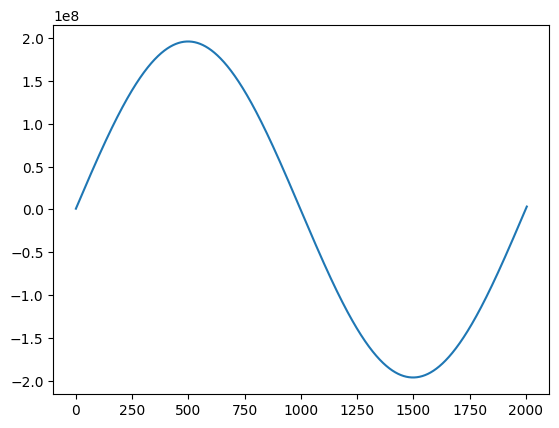

In [251]:
plt.plot(E_0 * np.sin( angular_frequency * t - wavenumber * x[0] ))

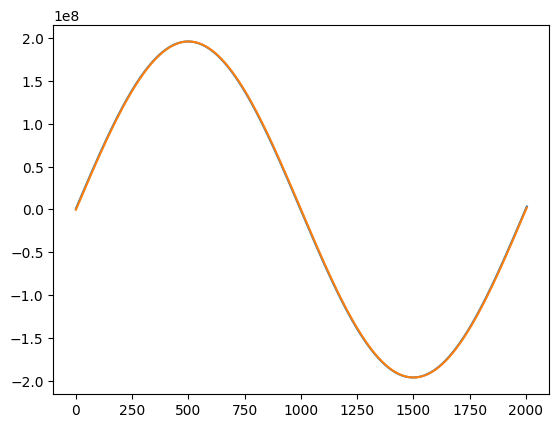

In [262]:
plt.plot(cos_term_0_t_nm1)
plt.plot(cos_term_1_t_nm1)
plt.show()

In [ ]:
cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t))
sin_term_0_t_n = E_0 * np.sin((wavenumber * x[0]) - (angular_frequency * t))

cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t))
sin_term_1_t_n = E_0 * np.sin((wavenumber * x[1]) - (angular_frequency * t))

In [254]:
cos_term_0_t_nm1

923112.9862372458

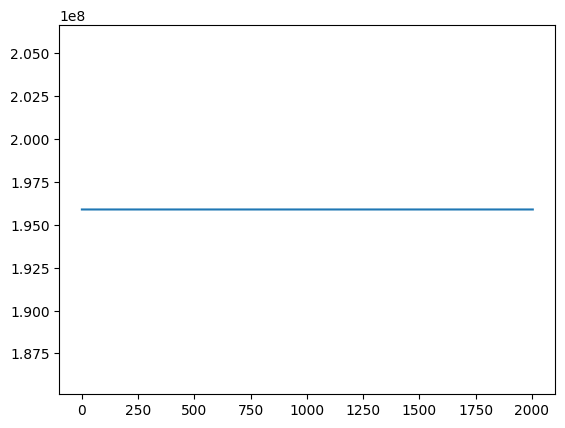

In [244]:
plt.plot(np.sqrt(cos_term_1_t_nm1 ** 2 + sin_term_1_t_nm1 ** 2))

In [289]:
from scipy.ndimage import gaussian_filter1d

In [ ]:
plt.plot(x/nm, gaussian_filter1d(E[2000, :].real, 5))

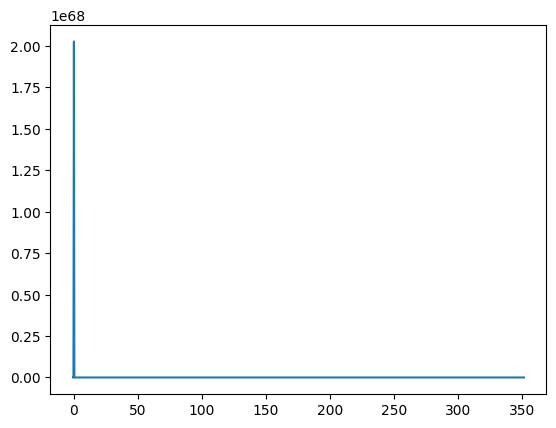

In [382]:
plt.plot(x/nm, E[9999, :])

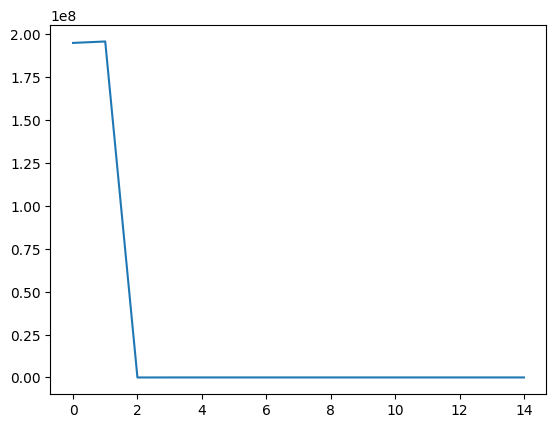

In [92]:
plt.plot(E[10,:])

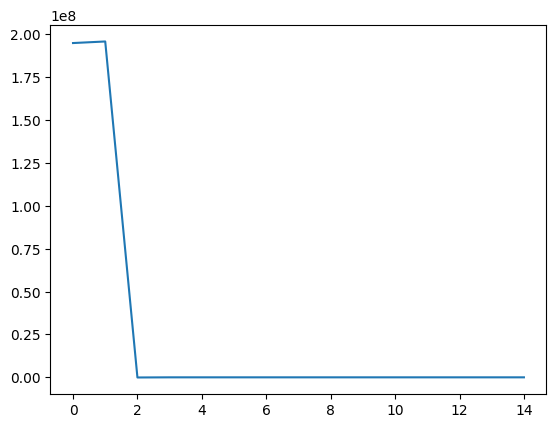

In [93]:
plt.plot(E[20, :])

In [ ]:
plt.plot()

In [85]:
(delta_t * 820) / period 

0.082

In [42]:
r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2

In [43]:
r_const_complex

(-0.00022620085993920567-6.0381765805633185e-05j)

In [38]:
complex(cos_term_0_t_nm1, sin_term_0_t_nm1)

(76350402.8111051-6491847.304042041j)

## Laser source

Plot an animated wave through time.

In [ ]:
plt.plot(E)
plt.legend
plt.show()

In [ ]:
%matplotlib notebook

In [ ]:
Y_UPPER_LIMIT = 3 * 10**8
Y_LOWER_LIMIT = -3 * 10**8

In [ ]:
fig, ax = plt.subplots()
ax.set(xlim=(0, 100), ylim=(Y_LOWER_LIMIT, Y_UPPER_LIMIT))

line = ax.plot(x, E[:,0], color='k', lw=2)[0]

def animate(i):
    line.set_ydata(E[:,i])
    
anim = FuncAnimation(fig, animate, interval=1, frames=100)
 
anim.save('filename.gif')
    
# plt.draw()
plt.show()

In [ ]:
# initializing a figure in 
# which the graph will be plotted
fig = plt.figure() 
   
# marking the x-axis and y-axis
axis = plt.axes(xlim=(0, 100), ylim=(Y_LOWER_LIMIT, Y_UPPER_LIMIT)) 
  
# initializing a line variable
line, = axis.plot([], [], lw = 3) 

# data which the line will 
# contain (x, y)
def init(): 
    line.set_data([])
    return line,
   
def animate(i):
#     x = np.linspace(0, 4, 1000)
   
    # plots a sine graph
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(E[i])
      
    return line,
   
anim = FuncAnimation(fig, animate, init_func = init,
                     frames = 1, interval = 20, blit = True)
  
anim.save('test.gif')

plt.show()